<img src="images/header.png" alt="Header" style="width: 400px;"/>
<h1 align="center">Predictive Maintenance using NVIDIA RAPIDS and Deep Learning Models</h1>
<h4 align="center">Part 3: Training Autoencoder for Anomaly Detection</h4>

## Overview

In the previous lab, we used LSTMs to predict hard drive failures. While timeseries prediction is a very well-studied approach in predictive maintenance, in this section we focus on a different deep learning technique, which is called __anomaly detection__. In a nutshell, considering the fact that only a small portion of the hard drives are defective in our use case, we can treat those as anomalies. For example, out of three million samples we dealt with in our training set within the previous lab, only 256 samples were defective. Those are "anomalies" among the big pool of well-functioning hard drives. Now, if we could have a model capable of learning what a proper functioning hard drive looks like, it could detect hard drives with a different behavior pattern.


This lab covers the following topics:

* [Autoencoders](#1)
    * [Exercise 1: Retrieve the output labels](#e1)
    * [Exercise 2: Sort data based on `seq_id` and `seq_data_id` columns](#e2)
    * [Exercise 3: Filtering the labels](#e2)
* [Testing Models](#2)
    * [LSTM Autoencoder Model](#3)
    * [1D Convolution Model](#3b)
* [Exercise 4: Experimenting with Hyperparameters](#e4)

In this lab, we will leverage the same Backblaze Hard Drive SMART data to train an Autoencoder model that will detect anomaly activity.  We'll leverage the time series sequences that we created in the previous step to train an Autoencoder Model to identify when there are significant variances from expected sensor data.  These variances can be used to alert support teams that there are potential issues with the system.

You'll see that autoencoders (AEs) are relatively easy to use, but let's first walk through the basics of using autoencoders.

We can use unsupervised learning algorithms like a deep autoencoder network to perform anomaly detection. A deep autoencoder takes an input X and attempts to map it back to itself; in essence, the autoencoder is trying to learn the identity function of the input data. Since learning the identity function is pretty trivial, we force the hidden layers of our autoencoder to be of lower dimensionality than the previous layer. This constraint forces the autoencoder to learn patterns in the data, and really learn efficient representations. 

<img src="img/AE_img-2.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 1. Using an autoencoder to map a timeseries data back to itself</p>

To train this type of neural network, we can calculate the difference between the input and the output and use that loss, typically called a reconstruction loss, as our loss function for training our model. The idea is that our autoencoder is essentially learning the data generating distribution for a unique dataset, and when we feed data generated from a different distribution into our autoencoder, our autoencoder will do a very poor job of reconstructing the input from the second source and our reconstruction error will be high; this indicates that our input is anomalous instead of just an extreme value.

<img src="img/AE_img-3.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 2. The predicted and ground-truth timeseries comparison after applying the autoencoder</p>



<a name="1"></a>
## Autoencoders

Autoencoders are a subset of neural network architectures where the output dimension is the same as the input dimension. Autoencoders have two networks, an encoder and a decoder.  The encoder encodes its input data into a smaller dimensional space, called the latent space.  The decoder network tries to reconstruct the original data from the latent encoding. Typically, the encoder and decoder are symmetric, and the latent space is a bottleneck. The autoencoder has to learn essential characteristics of the data to be able to do a high-quality reconstruction of the data during decode.



<img src="img/AE_img-1.png" style="margin-top:10px;"/>
<p style="text-align: center;color:gray"> Figure 3.  Structure of an auto-encoder model</p>

Autoencoders can be built using many different layer types based on the desire goal of the model.  In this lab, we'll experiment using two different autoencoder models.  One built with LSTM layers and one built on top of 1D-Convolution.  You'll have the opportunity to test both.  Additionally, you'll see that we leverage Dropout layers as a way to control overfitting by randomly omitting subsets of features at each iteration of a training procedure. To begin, let’s import some libraries that we are going to use throughout this lab.

In [1]:
# Import libraries that will be needed for the lab
import os
import sys
import time
import logging
import importlib
import numpy as np
import pandas as pd
import collections
from tqdm import tqdm


import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc,precision_recall_fscore_support, average_precision_score, precision_recall_curve, auc, confusion_matrix,accuracy_score

from keras import initializers, regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Input, LSTM, BatchNormalization, LeakyReLU, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise, MaxPooling2D, concatenate

from keras import backend as K

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import *

import pickle
import gc

from hyperparam import Hyperparameter 
import random
!pip install bayesian-optimization
random.seed(123)

/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/rapids/lib/python3.6/site-packages/tensorflow/python/framework/dty

<a name="1b"></a>
### Input Data Set

In [2]:
data_dir = "./data/"

print('Using 16-day sequence data set')
sequence_length = 16        # Number of days in sequence to train
wsize = 16
train_fname = data_dir + 'Lab3-AE-train-16day-8step.pkl'
test_fname = data_dir + 'Lab3-AE-test-16day-8step.pkl'

Using 16-day sequence data set


### Data Set Information

As we experienced in the previous exercises, preparing large data sets can take some time.  So, for this exercise, we have created larger training and validation datasets which we will use for our training and testing.  

The datasets consists of 50000 sequences.  Each sequence is for an individual drive and tracks the SMART data features over 7 continuous days.  Since we will be training an Autoencoder to identify sequences for normal hard drive operation, we have not include any sequences that ended in drive failures.

When we created these sequences, we assigned them a sequence id (field: "ae_seq_id") and a day number in the sequence (field: "ae_seq_data_id" which goes from 0-15).

### Reading Training and Validation Datasets

In [3]:
# Reading larger training and test data set with only ST4000DM000 data
df = pd.read_pickle(train_fname)
print('Train Original shape:', df.shape)

Train Original shape: (74000, 46)


Let's take a look at our data set.  We'll print out the first 2 sequences.  You'll see the sequence id fields we discussed above.

In [4]:
df.head(2*sequence_length)

,ae_seq_id,ae_seq_data_id,date,serial_number,model,capacity_bytes,failure,smart_1_raw,smart_4_raw,smart_5_raw,...,smart_184_normalized,smart_187_normalized,smart_188_normalized,smart_189_normalized,smart_190_normalized,smart_193_normalized,smart_194_normalized,smart_197_normalized,smart_198_normalized,smart_199_normalized
195468,0.0,0.0,2017-07-28,Z300HM1N,ST4000DM000,4.000787e+12,0.0,169386552.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195469,0.0,1.0,2017-07-29,Z300HM1N,ST4000DM000,4.000787e+12,0.0,220437952.0,24.0,0.0,...,100.0,100.0,100.0,94.0,76.0,72.0,24.0,100.0,100.0,200.0
195470,0.0,2.0,2017-07-30,Z300HM1N,ST4000DM000,4.000787e+12,0.0,12172112.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195471,0.0,3.0,2017-07-31,Z300HM1N,ST4000DM000,4.000787e+12,0.0,33350928.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195472,0.0,4.0,2017-08-01,Z300HM1N,ST4000DM000,4.000787e+12,0.0,98402824.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195473,0.0,5.0,2017-08-02,Z300HM1N,ST4000DM000,4.000787e+12,0.0,173407640.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195474,0.0,6.0,2017-08-03,Z300HM1N,ST4000DM000,4.000787e+12,0.0,59425848.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195475,0.0,7.0,2017-08-04,Z300HM1N,ST4000DM000,4.000787e+12,0.0,178379120.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195476,0.0,8.0,2017-08-05,Z300HM1N,ST4000DM000,4.000787e+12,0.0,21791640.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0
195477,0.0,9.0,2017-08-06,Z300HM1N,ST4000DM000,4.000787e+12,0.0,151298144.0,24.0,0.0,...,100.0,100.0,100.0,94.0,75.0,72.0,25.0,100.0,100.0,200.0


### Data preparation Routines

To work with the data, we are going to build a more structured set of functions that are going to help us with data curation. As stated in the previous lab, the dataset contains duplicated columns with "normalized" data. Our first function, `remove_normalized`, is aimed to remove those.

In [5]:
# Remove the "normalized" columns which are simply nomralized copies of the "raw" column

def remove_normalized(df):
    cols = [c for c in df.columns if (c.lower().find("normalized")==-1)]
    df=df[cols]
    return df

<a name="e1"></a>

### Exercise 1: Retrieve the output labels

We would like to get the failure column in NumPy format. Complete the following function to perform this task:

In [7]:
def get_Labels(df):
    # return the proper column in NumPy format
    y_labels = df['failure'].values
    return y_labels

If you get stuck, click [here](#a1) for an answer.

<a name="e2"></a>

### Exercise 2: Sort data based on `ae_seq_id` and `ae_seq_data_id` columns

Prior to training, we need to ensure that all the data is properly sorted so that sequences are presented in the correct order.  When we created the data set for this exercise, we added two fields:
<ul>
    <li>ae_seq_id: ID number of sequence</li>
    <li>ae_seq_data_id: day number of record in sequence (day 0 - day (sequence_length-1))</li>
</ul>

Please correct the To Do section below to properly sort data frame (ascending) by <b>ae_seq_id</b> and <b>ae_seq_data_id</b>.

In [8]:
# Sort data frame - not needed as data is already sorted - needs to be reviewed

def sort_dataframe(df):
    print("Sorting the data frame based on serial number and date")
    df['date'] = pd.to_datetime(df['date'])
    
    #sort dataframe by 'serial_number' and 'date'
    df = df.sort_values(by=['ae_seq_id', 'ae_seq_data_id'], axis=0, ascending=True)
    df = df.reset_index(drop=True)
    return df

If you get stuck, click [here](#a2) for an answer.

Next we have created some "helper" functions to:
<ul>
    <li>Remove columns that possess no useful information for training</li>
    <li>Normalize the columns</li>
</ul>

In [9]:
# Remove columns unnecessary for training

def remove_columns(df, drop_columns_list = ['date','serial_number',
                                               'model', 
                                               'failure', 
                                               'capacity_bytes']):
    print("removing unnecessary columns")
    df = df.drop(columns=drop_columns_list)
    df = df.reset_index(drop=True)
    return df

In [10]:
# This routine removes the normalized features and removes unnecessary columns

def clean_dataframe(df,column_list=None):
        
    #sort the dataframe
    df = sort_dataframe(df)

    #remove normalized columns
    df = remove_normalized(df)

    #remove other unnecessary columns
    if column_list is not None:
        df = remove_columns(df, column_list)
    
    return df

# This routine scales values for training and reshapes data as appropriate for LSTM or CONV1D training

def normalize_df(df, ae_type=None):
    
    print("Normalizing input for "+ae_type)
    #normalize data with max/min values 
    df.fillna(0, inplace=True)
    x_train = df.values
    x_train = x_train.astype(np.float64)
    scaler = preprocessing.StandardScaler().fit(x_train)
    x_train = scaler.transform(x_train)
    
    #reshape to obtain appropriate input for autoencoder
    if ae_type == "lstm": 
        x_train = x_train.reshape(int(x_train.shape[0]/sequence_length), sequence_length, x_train.shape[1])
    elif ae_type == "conv1d": 
        tshape = x_train.shape
        print(tshape, "dropping ", tshape[0]-int(tshape[0]/w_size)*w_size, end = " : reshaping to ")       
        x_train = x_train[:int(tshape[0]/w_size)*w_size,:].reshape(int(tshape[0]/w_size), w_size, tshape[1])

    print(x_train.shape)
    
    return x_train


We are going to load both training and test sets below, starting with the training set. Note that unlike the LSTM models, here we do not require the `failure` columns. The class labels are not what we learn, rather we learn the training data pattern. In that sense, autoencoders are unsupervised models.

In [11]:
print("processing the train set")

df = clean_dataframe(df,['ae_seq_id', 
                            'ae_seq_data_id', 
                            'date','serial_number',
                            'model', 
                            'failure', 
                           'capacity_bytes'])

x_train = normalize_df(df,"lstm")

processing the train set
Sorting the data frame based on serial number and date
removing unnecessary columns
Normalizing input for lstm
(4625, 16, 21)


Let's take a look at a few samples of the data.

In [12]:
df.head(2*sequence_length)

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,169386552.0,24.0,0.0,11790406.0,34692.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57729.0,25.0,0.0,0.0,0.0,34450.0,3.177469e+10,1.425277e+11
1,220437952.0,24.0,0.0,12531683.0,34716.0,24.0,1.0,0.0,0.0,0.0,...,24.0,14.0,57731.0,24.0,0.0,0.0,0.0,34474.0,3.177673e+10,1.425649e+11
2,12172112.0,24.0,0.0,13249488.0,34740.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34498.0,3.177876e+10,1.426023e+11
3,33350928.0,24.0,0.0,13970733.0,34764.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34522.0,3.178076e+10,1.426377e+11
4,98402824.0,24.0,0.0,14725252.0,34788.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34546.0,3.178302e+10,1.426726e+11
5,173407640.0,24.0,0.0,15477836.0,34812.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34570.0,3.178512e+10,1.427067e+11
6,59425848.0,24.0,0.0,16264486.0,34836.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34594.0,3.178752e+10,1.427406e+11
7,178379120.0,24.0,0.0,17053336.0,34860.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34618.0,3.178998e+10,1.427768e+11
8,21791640.0,24.0,0.0,17824256.0,34884.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34642.0,3.179215e+10,1.428109e+11
9,151298144.0,24.0,0.0,18616634.0,34908.0,24.0,1.0,0.0,0.0,0.0,...,25.0,14.0,57731.0,25.0,0.0,0.0,0.0,34666.0,3.179427e+10,1.428451e+11


Next, we are going to load the test set. Unlike, the train set, we require the `failure` column for the test set to evaluate the model accuracy at the end. Again, you can see that we are using the processed dataset from the previous lab for our test purposes.

In [13]:
df_test = pd.read_pickle(test_fname)
y_labels = get_Labels(df_test)

df_test = clean_dataframe(df_test, ['ae_seq_id', 'ae_seq_data_id', 'date','serial_number','model', 
                            'failure', 
                            'capacity_bytes'])

x_test = normalize_df(df_test,'lstm')

Sorting the data frame based on serial number and date
removing unnecessary columns
Normalizing input for lstm
(834, 16, 21)


In [14]:
df_test.head(2*sequence_length)

,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,...,smart_190_raw,smart_192_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,20931656.0,5.0,0.0,445083804.0,10497.0,5.0,0.0,0.0,0.0,0.0,...,19.0,0.0,19298.0,19.0,0.0,0.0,0.0,10389.0,3.606082e+10,8.751856e+09
1,172359472.0,5.0,0.0,445791739.0,10521.0,5.0,0.0,0.0,0.0,0.0,...,19.0,0.0,19298.0,19.0,0.0,0.0,0.0,10413.0,3.609658e+10,8.776299e+09
2,21705248.0,5.0,0.0,447586660.0,10545.0,5.0,0.0,0.0,0.0,0.0,...,19.0,0.0,19298.0,19.0,0.0,0.0,0.0,10437.0,3.614011e+10,8.817362e+09
3,129069792.0,5.0,0.0,448820783.0,10568.0,5.0,0.0,0.0,0.0,0.0,...,20.0,0.0,19298.0,20.0,0.0,0.0,0.0,10461.0,3.617421e+10,8.851069e+09
4,68452888.0,5.0,0.0,449512275.0,10593.0,5.0,0.0,0.0,0.0,0.0,...,20.0,0.0,19298.0,20.0,0.0,0.0,0.0,10485.0,3.621012e+10,8.869208e+09
5,59189440.0,5.0,0.0,449985857.0,10617.0,5.0,0.0,0.0,0.0,0.0,...,20.0,0.0,19300.0,20.0,0.0,0.0,0.0,10509.0,3.624462e+10,8.878416e+09
6,117643832.0,5.0,0.0,451076087.0,10641.0,5.0,0.0,0.0,0.0,0.0,...,21.0,0.0,19300.0,21.0,0.0,0.0,0.0,10533.0,3.628199e+10,8.901264e+09
7,210523216.0,5.0,0.0,451546733.0,10665.0,5.0,0.0,0.0,0.0,0.0,...,21.0,0.0,19300.0,21.0,0.0,0.0,0.0,10557.0,3.631089e+10,8.910142e+09
8,2369744.0,5.0,0.0,451908456.0,10689.0,5.0,0.0,0.0,0.0,0.0,...,26.0,0.0,19300.0,26.0,0.0,0.0,0.0,10581.0,3.633408e+10,8.916714e+09
9,130718904.0,5.0,0.0,452575870.0,10713.0,5.0,0.0,0.0,0.0,0.0,...,23.0,0.0,19303.0,23.0,0.0,0.0,0.0,10605.0,3.638426e+10,8.928378e+09


<a name="e3"></a>
### Exercise 3: Filtering the labels

As for class labels, there is one extra filtering step. Take some time and try to figure the purpose behind the following command:

In [15]:
y_labels_seq = y_labels[sequence_length-1::sequence_length]

Since the "label" for the entire set of sequences is the label for the last day of the sequence, the above line finds the last failure label to label the entire sequence.

# Part 1 - LSTM based autoencoder or seq2seq model

<a name="2"></a>
## Defining the LSTM Autoencoder Model

In this section, we are going to define two autoencoder models. The first model uses LSTMs as autoencoders. In this model, we create the autoencoder for time sequences using LSTM encoder-decoder models. 

An LSTM unit could be thought of an encoder unit where the input data are represented as a vector of a hidden states. We use this concept to encode the input into 1024 __bottleneck__ vectors. Afterwards we use another set of two LSTM units to reconstruct the original series.

For the second model, we use a convolutional autoencoder. In this model, in order to encode the information, we use down-sampling (MaxPooling1D) and up-sampling (UpSampling1D) methods.



In [16]:
# Model #1 - Wide LSTM-based Encoder-Decoder
data_shape = x_train.shape[1:]   
    
## Some parameters to change
dp_lvl = 0.2
lstm_width = 128

inputs = Input(shape=(data_shape))
encoded = LSTM(lstm_width, dropout = dp_lvl, recurrent_dropout = dp_lvl, return_sequences =  False, activation='relu')(inputs)
decoded = RepeatVector(data_shape[0])(encoded)
decoded = LSTM(lstm_width, return_sequences=True, activation='relu')(decoded)
decoded = LSTM(data_shape[1], activation='tanh', return_sequences=True)(decoded)

# Build entire model
autoencoder = Model(inputs, decoded)

# Parameters to control learning rate
learning_rate = 0.001

optimizer = Adam(lr=learning_rate)
autoencoder.compile(optimizer=optimizer, loss='mae')
    
print(autoencoder.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16, 21)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               76800     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 16, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16, 128)           131584    
_________________________________________________________________
lstm_3 (LSTM)                (None, 16, 21)            12600     
Total params: 220,984
Trainable params: 220,984
Non-trainable params: 

We setup callback routines to two callback routines
<ul>
    <li>ModelCheckpoint - stores a copy of our model weights for our best training epoch.  This can be used for later deployments.</li>
    <li>EarlyStopping - stops the training early if the model is no longer improving.</li>
</ul>

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint
checkpoint = ModelCheckpoint(data_dir+"best_model_ae-lstm.h5", monitor='val_loss', 
                             verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(patience=15, verbose=1)

callbacks_list = [es, checkpoint]

<a name="3"></a>
## Training the LSTM model
Now that we've created our model, we'll go ahead and train it.  Then we'll evaluate the performance.

In [18]:
# train the model

# number of training epochs - feel free to change
#
# Time: 20 epochs ~= 5 minutes for LSTM

epochs_num = 20
history = autoencoder.fit(x_train, x_train, batch_size=128, epochs=epochs_num, validation_split=0.1, verbose=1, callbacks=callbacks_list) 


Instructions for updating:
Use tf.cast instead.
Train on 4162 samples, validate on 463 samples
Epoch 1/20
4162/4162 [==============================] - 11s 3ms/step - loss: 0.3935 - val_loss: 0.3204

Epoch 00001: val_loss improved from inf to 0.32044, saving model to ./data/best_model_ae-lstm.h5
Epoch 2/20
4162/4162 [==============================] - 2s 497us/step - loss: 0.3093 - val_loss: 0.2822

Epoch 00002: val_loss improved from 0.32044 to 0.28218, saving model to ./data/best_model_ae-lstm.h5
Epoch 3/20
4162/4162 [==============================] - 2s 517us/step - loss: 0.2797 - val_loss: 0.2600

Epoch 00003: val_loss improved from 0.28218 to 0.26004, saving model to ./data/best_model_ae-lstm.h5
Epoch 4/20
4162/4162 [==============================] - 2s 525us/step - loss: 0.2613 - val_loss: 0.2442

Epoch 00004: val_loss improved from 0.26004 to 0.24424, saving model to ./data/best_model_ae-lstm.h5
Epoch 5/20
4162/4162 [==============================] - 2s 515us/step - loss: 0.2502 -

Let's look at the loss function to see how accurate our training was.  

In [19]:
# load weights from best model
print(data_dir+"best_model_ae-lstm.h5")
autoencoder.load_weights(data_dir+"best_model_ae-lstm.h5")

./data/best_model_ae-lstm.h5


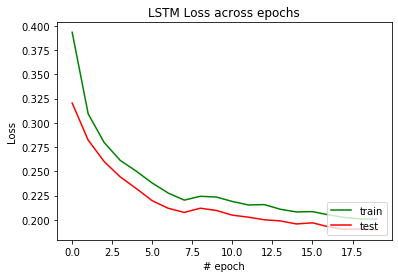

In [20]:
# show plot accuracy changes during training

plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'r')
plt.title('LSTM Loss across epochs')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

The model is starting to get trained, but at this point, the accuracy may not be that great.  In the real world, we train on even larger data sets for longer periods of time until the accurracy met our business requirements.  We also review the model and can increase it's complexity.

Let's go ahead and use our model to make predictions on the test data.  Remember, this is a reconstruction model, so the predictions, ideally, should look similar to the original data for normal disks.

In [21]:
# Use model to predict on test data set
y_pred = autoencoder.predict(x_test)

The next cell will plot a comparison of the original data to the predicted data for a random record. It compares the features for the first day in the sequence. Run it a few times to see how well your model came out.

This record is from an anomalous disk.


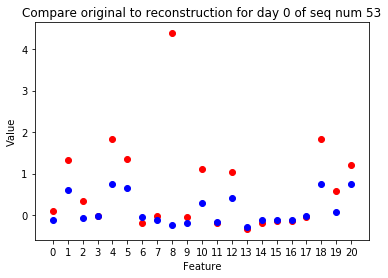

In [22]:
# create horizontal positions for scatter plot
x_pos = np.arange(x_test.shape[2])

# select random record
rec_num = random.randint(0, y_pred.shape[0])

# plot predicted points
plt.scatter(x_pos, x_test[rec_num,0,:], c="#ff0000")
plt.scatter(x_pos, y_pred[rec_num,0,:], c="#0000ff")

# label graph
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(range(x_test.shape[2]))
plt.title("Compare original to reconstruction for day 0 of seq num " + str(rec_num))

if y_labels_seq[rec_num] == 0:
    print("This record is from a normal disk.")
else:
    print("This record is from an anomalous disk.")    

You'll see that once you have a trained model, you need to determine a "threshold" of difference in detecting an anomaly. In our case, we know the number of normal disks and the number of anomalous disks. We'll calculate the MSE for each reconstruction and set our initial threshold based on that. This should be a good point to start the threshold at. In real world usage, you'll adjust the model and threshold to obtain accuracy to meet your business needs. In our case we'd like the recall to be as high as possible to identify as many failing disks as possible.

In [23]:
# Calcuate MSE for all sequences and predictions
import statistics

# determine median mse to split data into normal vs anomaly
pred_mse = []  # calculated mse for test data
pred_res = []  # result: 0 normal, 1 anomaly

for i in range(len(x_test)):
    pred_mse.append(mean_squared_error(y_pred[i,:,:], x_test[i,:,:]))

# Find number of disks that we know are normal and use that value as splitting point for data
num_normal_disks = list(y_labels_seq).count(0)

sort_mse = pred_mse.copy()
sort_mse.sort()
suggested_threshold = sort_mse[num_normal_disks]
print("Suggested Threshold:", suggested_threshold)

Suggested Threshold: 0.23519685646586272


In [24]:
# Routine to specify whether or not a sequence is anomalous

# specify override threshold or leave 0 to use suggested threshold
override_threshold = 0

if override_threshold == 0:
    threshold = suggested_threshold
else:
    threshold = override_threshold

for mse in pred_mse:
    if (mse <= threshold):
        pred_res.append(0)
    else:
        pred_res.append(1)
        
print("Used threshold:", threshold)
print("Resulting in the following classification of predicted data:")
print("- Normal Disks:   ", pred_res.count(0))
print("- Anomalous Disks:", pred_res.count(1))

Used threshold: 0.23519685646586272
Resulting in the following classification of predicted data:
- Normal Disks:    601
- Anomalous Disks: 233


Finally, let's create the confusion matrix.

In [25]:
print(classification_report(y_labels_seq, np.array(pred_res)))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       600
           1       0.61      0.60      0.60       234

    accuracy                           0.78       834
   macro avg       0.73      0.72      0.72       834
weighted avg       0.78      0.78      0.78       834



<a name="3b"></a>
## Training the 1D Convolutional model
Now that we've tested our LSTM model, let's create and train a 1D-Convolutional model.

In [26]:
checkpoint2 = ModelCheckpoint(data_dir+"best_model_ae-conv1d.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es2 = EarlyStopping(patience=15, verbose=1)

callbacks_list2 = [es2, checkpoint2]

Let's build out a 1D Convolution Model:

In [27]:
# Traditional Conv1D model

# Model parameter settings
sample_size = x_train.shape[1]
num_signals = x_train.shape[2]
dropout_rate = 0.2
outside_filters = 160
inside_filters = 80
ksize=6

# TTraditional 1D-Convolution Autoencoder

input_data = Input(shape=(sample_size, num_signals))
# --- Encode ---
encoded = Conv1D(filters=outside_filters, kernel_size=ksize, activation="relu", padding="same")(input_data)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
encoded = Conv1D(filters=inside_filters, kernel_size=ksize, activation="relu", padding="same")(encoded)
encoded = MaxPooling1D(pool_size=2)(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
# --- Encodings ---
encoded = Conv1D(filters=4, kernel_size=ksize, activation="relu", padding="same")(encoded)
encoded = Dropout(rate=dropout_rate)(encoded)
# --- Decode ---
decoded = UpSampling1D(size=2)(encoded)
decoded = Conv1D(filters=inside_filters, kernel_size=ksize, activation="relu", padding="same")(decoded)
decoded = Dropout(rate=dropout_rate)(decoded)
decoded = UpSampling1D(size=2)(decoded)
decoded = Conv1D(filters=outside_filters, kernel_size=ksize, activation="relu", padding="same")(decoded)
decoded = Dropout(rate=dropout_rate)(decoded)
# --- Output ---
output_layer = Conv1D(filters=num_signals, kernel_size=1, activation="linear", padding="same")(decoded)
autoencoder2 = Model(input_data, output_layer)
lr = 1e-3 # learning rate
autoencoder2.compile(optimizer = "adam", loss = "mse", metrics = ["accuracy"])
autoencoder2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 21)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 160)           20320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 160)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 160)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 8, 80)             76880     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 80)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 80)             0   

In [28]:
# train the model

# number of training epochs - feel free to change
#
#       50 epochs ~= 4 minutes for Conv 1D

epochs_num = 60
history2 = autoencoder2.fit(x_train, x_train, batch_size=128, epochs=epochs_num, validation_split=0.1, verbose=1, callbacks=callbacks_list2)


Train on 4162 samples, validate on 463 samples
Epoch 1/60
4162/4162 [==============================] - 2s 527us/step - loss: 0.9210 - acc: 0.0987 - val_loss: 0.5271 - val_acc: 0.3018

Epoch 00001: val_loss improved from inf to 0.52708, saving model to ./data/best_model_ae-conv1d.h5
Epoch 2/60
4162/4162 [==============================] - 0s 45us/step - loss: 0.8011 - acc: 0.2135 - val_loss: 0.4297 - val_acc: 0.3032

Epoch 00002: val_loss improved from 0.52708 to 0.42973, saving model to ./data/best_model_ae-conv1d.h5
Epoch 3/60
4162/4162 [==============================] - 0s 47us/step - loss: 0.7152 - acc: 0.2944 - val_loss: 0.4129 - val_acc: 0.2828

Epoch 00003: val_loss improved from 0.42973 to 0.41288, saving model to ./data/best_model_ae-conv1d.h5
Epoch 4/60
4162/4162 [==============================] - 0s 48us/step - loss: 0.6867 - acc: 0.3033 - val_loss: 0.4135 - val_acc: 0.2981

Epoch 00004: val_loss did not improve from 0.41288
Epoch 5/60
4162/4162 [==============================

In [29]:
# load weights from best model
print(data_dir+"best_model_ae-conv1d.h5")
autoencoder2.load_weights(data_dir+"best_model_ae-conv1d.h5")

./data/best_model_ae-conv1d.h5


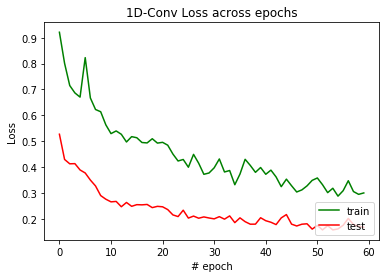

In [30]:
# show plot accuracy changes during training

plt.plot(history2.history['loss'],'g')
plt.plot(history2.history['val_loss'],'r')
plt.title('1D-Conv Loss across epochs')
plt.ylabel('Loss')
plt.xlabel('# epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

Let's go ahead and use our model to make predictions on the test data. Remember, this is a reconstruction model, so the predictions, ideally, should look similar to the original data for normal disks.

In [31]:
# Use model to predict on test data set
y_pred2 = autoencoder2.predict(x_test)

The next cell will plot a comparison of the original data to the predicted data for a random record. It only shows compares the features for the first day in the sequence. Run it a few times to see how well your model came out.

This record is from a normal disk.


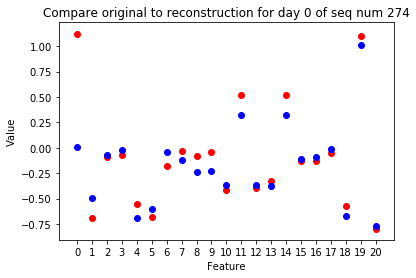

In [32]:
# create horizontal positions for scatter plot
x_pos = np.arange(x_test.shape[2])

# select random record
rec_num = random.randint(0, y_pred.shape[0])

# plot predicted points
plt.scatter(x_pos, x_test[rec_num,0,:], c="#ff0000")
plt.scatter(x_pos, y_pred2[rec_num,0,:], c="#0000ff")

# label graph
plt.xlabel("Feature")
plt.ylabel("Value")
plt.xticks(range(x_test.shape[2]))
plt.title("Compare original to reconstruction for day 0 of seq num " + str(rec_num))

if y_labels_seq[rec_num] == 0:
    print("This record is from a normal disk.")
else:
    print("This record is from an anomalous disk.") 

Like before, we need to determine a "threshold" of difference in detecting an anomaly. We'll use the same technique on the new data to determine our threshold.

In [33]:
# Calcuate MSE for all sequences and predictions
import statistics

# determine median mse to split data into normal vs anomaly
pred_mse2 = []  # calculated mse for test data
pred_res2 = []  # result: 0 normal, 1 anomaly

for i in range(len(x_test)):
    pred_mse2.append(mean_squared_error(y_pred2[i,:,:], x_test[i,:,:]))

# Find number of disks that we know are normal and use that value as splitting point for data
num_normal_disks = list(y_labels_seq).count(0)

sort_mse2 = pred_mse2.copy()
sort_mse2.sort()
suggested_threshold2 = sort_mse2[num_normal_disks]
print("Suggested Threshold:", suggested_threshold2)

Suggested Threshold: 0.23952569729644316


In [34]:
# Routine to specify whether or not a sequence is anomalous

# specify override threshold or leave 0 to use suggested threshold
override_threshold2 = 0

if override_threshold2 == 0:
    threshold2 = suggested_threshold2
else:
    threshold2 = override_threshold2

for mse in pred_mse2:
    if (mse <= threshold2):
        pred_res2.append(0)
    else:
        pred_res2.append(1)
        
print("Used threshold:", threshold2)
print("Resulting in the following classification of predicted data:")
print("- Normal Disks:   ", pred_res2.count(0))
print("- Anomalous Disks:", pred_res2.count(1))

Used threshold: 0.23952569729644316
Resulting in the following classification of predicted data:
- Normal Disks:    601
- Anomalous Disks: 233


Finally, let's create the confusion matrix:

In [35]:
# Needs to be reviewed...
print(classification_report(y_labels_seq, np.array(pred_res2)))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       600
           1       0.60      0.59      0.60       234

    accuracy                           0.77       834
   macro avg       0.72      0.72      0.72       834
weighted avg       0.77      0.77      0.77       834



### Performance comparison of LSTM and 1D-Conv models

Now that you've tested both LSTM and the 1D Convultional anomaly detectors, how do you think their accuracy and performance compared?

In [36]:
# Put your answer here

<a name="e4"></a>
### Optional Exercise 4: Experimenting with Hyperparameters

Now that you've worked your through the entire notebook, feel free to go back and adjust the models to see if you can improve accuracy.  You can add layers, increase filters, and change hyperparameters.  This is where the real art of Deep Learning happens...

However, it is possible to take a systematic approach to hyperparameter optimization by sweeping the space of all parameter values and finding those which maximize some metric you're interested in.  We can then define a function to construct our model based on a given set of parameters, as well as define a scoring function which creates and trains the model and evaluates it's performance. There are many approaches to perform hyperparameter optimization using Deep Learning models. We will explore one concept called Bayesian Optimization which is a fairly common approach for this type of optimization.  

In this example, we'll continue with the LSTM model designed previously and set up the parameter search space to include adjusting the dropout rate and LSTM width along with a factor describing how much of the suggested threshold to use when classifying a defective disk.  In more complicated models, other hyperparameters such as the number of stacked LSTM layers or convolution kernel width could be included in the search space.  Just keep in mind that each new parameter will expand the search space and require more time to maximize.

In [37]:
from bayes_opt import BayesianOptimization

Now we can create a function to construct a model based on some static parameters in addition to the variable sweep parameters:

In [38]:
# Model #1 - Wide LSTM-based Encoder-Decoder
data_shape = x_train.shape[1:]  

dp_lvl = 0.2

def lstm_autoencoder(data_shape, params):
    
    inputs = Input(shape=(data_shape))
    encoded = LSTM(int(params["lstm_width"]), dropout = dp_lvl, recurrent_dropout = dp_lvl, return_sequences =  False, activation='relu')(inputs)
    decoded = RepeatVector(data_shape[0])(encoded)
    decoded = LSTM(int(params["lstm_width"]), return_sequences=True, activation='relu')(decoded)
    decoded = LSTM(data_shape[1], activation='tanh', return_sequences=True)(decoded)

    # Build entire model
    autoencoder = Model(inputs, decoded)
    
    if print_flag == 1:
        print(autoencoder.summary())
    return autoencoder

Next define a function to train the model and return the accuracy:

In [39]:
import statistics
from keras.callbacks import ModelCheckpoint, EarlyStopping

epochs_num = 20
 
current_batch_size = 128 
print_flag = 0 

def train_and_fit_lstm(lstm_width_unscaled,learning_rate_unscaled):

    lstm_width_unscaled=int(np.round(lstm_width_unscaled))
    
    time_start = time.time()
    mod_params = {} 
    mod_params['lstm_width'] = lstm_width.from_unscaled(lstm_width_unscaled)
    mod_params['learning_rate'] = learning_rate.from_unscaled(learning_rate_unscaled)
    
    current_param_str = "lstm_width %d, learning_rate %5f," %(mod_params['lstm_width'],mod_params['learning_rate'])
    
    autoencoder = lstm_autoencoder(data_shape, mod_params)
   
    filename=data_dir+"case_%.3e_%d_best_model_ae-lstm.h5" % (mod_params["learning_rate"],mod_params["lstm_width"])

    # checkpoint
    checkpoint = ModelCheckpoint(data_dir+"case_%.3e_%d_best_model_ae-lstm.h5" %  
                                 (mod_params["learning_rate"],mod_params["lstm_width"]), monitor='val_loss', 
                                 verbose=print_flag, save_best_only=True, mode='min')
    es = EarlyStopping(patience=15, verbose=print_flag)
    
    callbacks_list = [es, checkpoint]

    optimizer = Adam(lr=mod_params['learning_rate'])
    autoencoder.compile(optimizer=optimizer, loss='mae')

    result = -1
    try:
        history = autoencoder.fit(x_train, x_train, batch_size=current_batch_size, epochs=epochs_num, validation_split=0.1, verbose=print_flag, callbacks=callbacks_list)

        # Use model to predict on test data set
        y_pred = autoencoder.predict(x_test)    

        # Calcuate MSE for all sequences and predictions

        # determine median mse to split data into normal vs anomaly
        pred_mse = []  # calculated mse for test data
        pred_res = []  # result: 0 normal, 1 anomaly

        for i in range(len(x_test)):
            pred_mse.append(mean_squared_error(y_pred[i,:,:], x_test[i,:,:]))

        # Find number of disks that we know are normal and use that value as splitting point for data
        num_normal_disks = list(y_labels_seq).count(0)
        
        sort_mse = pred_mse.copy()
        sort_mse.sort()
        threshold = sort_mse[num_normal_disks]

        for mse in pred_mse:
            if (mse <= (threshold * 1.2)):#params["threshold_factor"])):
                pred_res.append(0)
            else:
                pred_res.append(1)

        cr = classification_report(y_labels_seq, np.array(pred_res), output_dict=True)

        plt.figure()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        
        plt.ylabel('Loss')
        plt.xlabel('# epoch')
        plt.legend(['train', 'test'], loc='lower right')
        plt.ylim([0.15,0.55])
        result = cr['weighted avg']['precision']
        plt.title('LSTM Loss across epochs   \n ' + current_param_str + " precision %7.4f" % (result))
    
    except:
        result = -1
    
    print(current_param_str, "  precision %7.4f in %.3f mins" % (result, (time.time()-time_start)/60.0))
    return result


Let's define the parameter space:

In [40]:
lstm_width = Hyperparameter({"min": 32, "max": 128, "count": 9, "type" : "int" })
learning_rate = Hyperparameter({"min": 0.0001, "max": 0.1, "scale" : "log"})

pbounds = {"lstm_width_unscaled"       : (0,lstm_width.count-1),
           "learning_rate_unscaled"    : (0,learning_rate.count-1)}

 Hyperparameter (min: 32, max: 128, scale: linear, step: 12, count: 9, type: int)
 Hyperparameter (min: 0.0001, max: 0.1, scale: log, step: 0.6907755278982137, count: 11, type: float)


Test the input function for optimization:

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 16, 21)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               76800     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 16, 128)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 128)           131584    
_________________________________________________________________
lstm_6 (LSTM)                (None, 16, 21)            12600     
Total params: 220,984
Trainable params: 220,984
Non-trainable params: 0
_________________________________________________________________
None
Train on 4162 samples, validate on 463 samples
Epoch 1/20
4162/4162 [==============================] - 4s 1ms/step

0.7564735981292422

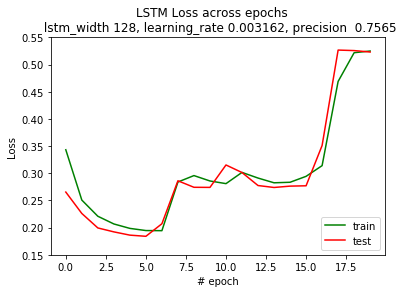

In [41]:
print_flag = 1
train_and_fit_lstm(8,5 )

Define Bayesian Optimization using the input function:

In [42]:
optimizer = BayesianOptimization(
    f=train_and_fit_lstm,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=1,
)

Run the optimizer to explore the parameter space:

|   iter    |  target   | learni... | lstm_w... |
-------------------------------------------------
lstm_width 104, learning_rate 0.001783,   precision  0.8091 in 0.854 mins
|  1        |  0.8091   |  4.17     |  5.763    |
lstm_width 56, learning_rate 0.000100,   precision  0.7683 in 0.891 mins
|  2        |  0.7683   |  0.001144 |  2.419    |
lstm_width 44, learning_rate 0.000276,   precision  0.7707 in 0.883 mins
|  3        |  0.7707   |  1.468    |  0.7387   |
lstm_width 68, learning_rate 0.000362,   precision  0.7912 in 0.900 mins
|  4        |  0.7912   |  1.863    |  2.764    |
lstm_width 32, learning_rate 0.100000,   precision  0.7470 in 0.776 mins
|  5        |  0.747    |  10.0     |  0.0      |
lstm_width 128, learning_rate 0.094066,   precision -1.0000 in 0.694 mins
|  6        | -1.0      |  9.911    |  7.995    |
lstm_width 128, learning_rate 0.000100,   precision  0.7820 in 0.975 mins
|  7        |  0.782    |  0.0      |  8.0      |


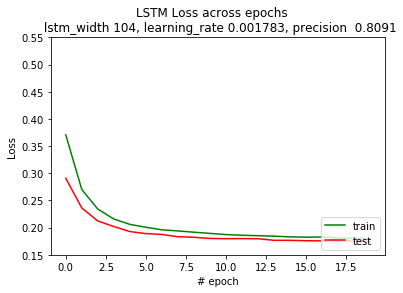

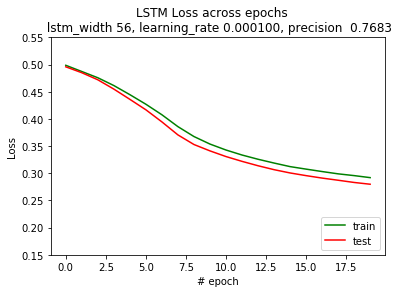

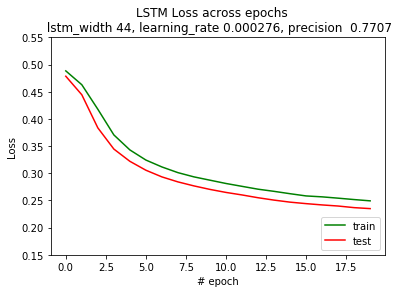

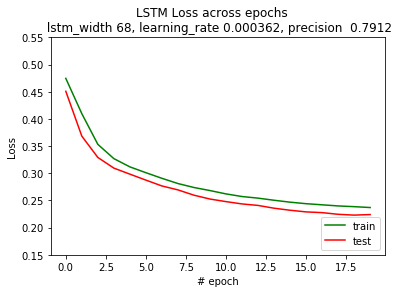

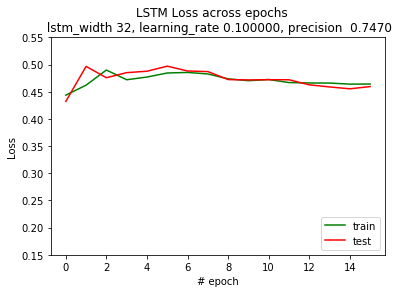

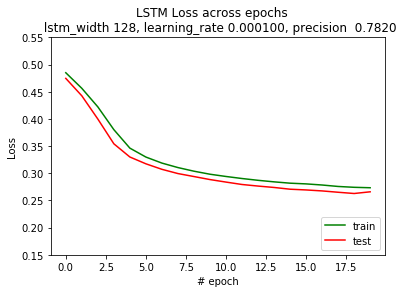

In [43]:
print_flag = 0
optimizer.maximize(
    init_points=4,
    n_iter=3,
)

## Summary

In this course, we tackled the predictive maintenance problem using different approaches. Mainly, we used a machine-learning-based approach called XGBoost to classify the defective hard drive samples. Next, we used recurrent neural networks to predict hard drive feature sequences and indicate whether the timeseries ends in a fail state or not. Finally, we used an anomaly detection approach to classify samples into defective/normal bins.
One important factor affecting the outcome of all the models experimented in this course, is the number of data sequences. While we had the liberty of choosing among a dataset of 6M samples, the defective hard drives were significantly less. This challenge affected the outcome of the models discussed so far. To overcome similar issues in industrial applications, the reader is encouraged to investigate data augmentation techniques to increase the training set.

<a name="All-answers"></a>
## Answers to selected exercises:
---

<a name="a1"></a>

**Exercise 1: More insights into data:**



In [44]:
y_labels = df['failure'].values

KeyError: 'failure'

Click [here](#e1) to go back

<a name="a2"></a>

**Exercise 2: Sort data based on `ae_seq_id` and `ae_seq_data_id` columns**

In [ ]:
# sort by seq id and place in sequence
df = df.sort_values(by=['ae_seq_id', 'ae_seq_data_id'], axis=0, ascending=True)

Click [here](#e2) to go back

### Optional Conv1D Model

There are a number of possible 1D Convolutional models.  Here's another option:

In [ ]:
# Model #2 - 1D-Convolution Autoencoder

nsens = x_valid.shape[2]

# Define the input shape
input_data = Input(shape=(wsize, nsens))

# Add first convolution layer and pooling layer
x = Conv1D(filters=32,kernel_size=5,activation="relu",padding="same")(input_data)
x = MaxPooling1D(2)(x)

# Add second convolution layer
x = Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(x)

m, n = x.get_shape().as_list()[1:]
x = Flatten()(x)
x = Dense(128,activation="relu")(x)
x = Dense(m*n,activation="relu")(x)
x = Reshape((m,n))(x)
x = Conv1D(filters=64,kernel_size=5,activation="relu",padding="same")(x)
x = UpSampling1D(2)(x)
x = Conv1D(filters=32,kernel_size=5,activation="relu",padding="same")(x)
output_layer = Conv1D(filters=nsens,kernel_size=5,activation="linear",padding="same")(x)
autoencoder = Model(input_data,output_layer)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()